# Exploration for corpus stats and initial topic modeling experiments

In [1]:
from pathlib import Path
import string

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer 
import seaborn as sns


In [2]:
# Reusable functions 
def get_stop_list(stop_file):
    """Returns a set of stop words from file where
    they're one per line
    :param stop_file: Path object
    """
    text = stop_file.read_text(encoding="utf-8")
    stops = set([s.strip() for s in text.split("\n")])
    if '' in stops:
        stops.remove('')
    return stops


def get_stopped_text(text, stop_set):
    """Remove stop words from text after splitting
    on whitespace
    :param text: str
    :param stop_set: set of str
    """
    return " ".join([s for s in text.split() if s.lower() not in stop_set])


def get_clean_text(text, keep_set):
    """Downcase and strip punctuation
    #TODO Use Mallet's tokenization regex

    :param text: str
    :param keep_set: set of str, words that should be kept
    """
    tmp = text.translate(str.maketrans('', '', string.punctuation)).lower()
    return " ".join([t for t in tmp.split() if t in keep_set])


def get_num_tokens(text):
    """Returns the number of tokens after splitting on whitespace.
    #TODO Use Mallet's tokenization regex

    :param text: str
    """
    return len(text.split())


def get_by_author_statistics(corpus_df, author_col, doc_length_col):
    """Returns a dataframe with by author statistics for total number of documents ('doc_count'), 
    total number of tokens ('token_count') and normalized document length ('normalized_doc_length')

    :param corpus_df: DataFrame containing the specified columns author_col and doc_length_col where each row is a doc
    :param author_col: str, column containing author ids
    :param doc_length_col: str, column with numeric document length
    """
    author_groupby = corpus_df.groupby(author_col)
    docs_by_author = author_groupby.size().reset_index(name='doc_count')
    tokens_by_author = author_groupby[doc_length_col].sum().reset_index(name='token_count')
    normalized_tokens_by_author = pd.merge(docs_by_author, tokens_by_author, on='author')
    normalized_tokens_by_author['normalized_doc_length'] = normalized_tokens_by_author['token_count'] / normalized_tokens_by_author['doc_count']
    return normalized_tokens_by_author


def get_by_author_word_counts(corpus_df, text_col, author_col):
    """Gets word counts by author using the specified text_col as
    documents. Expects a DataFrame with a column of free text 
    where each row is a document and with a categorical column for 
    the author. Does counts using sklearn's CountVectorizer. 
    # TODO Give CountVectorizer the vocab list from Mallet
    # TODO Give CountVectorizer Mallet's tokenization regex

    :param corpus_df: The original DataFrame
    :param text_col: The name of the column storing free text
    :param author_col: The name of the column storing author ids
    """
    all_author_counts = pd.DataFrame()
    authors = set(corpus_df[author_col])
    for a in authors:
        author_texts = list(corpus_df[corpus_df[author_col]==a][text_col])
        cv = CountVectorizer()
        # each column represents a word, each row a document for that author
        author_count = cv.fit_transform(author_texts)
        # sum column to get single word counts for that author over all docs
        total_author_counts = author_count.toarray().sum(axis=0)
        author_df = pd.DataFrame(total_author_counts, columns = [a],
                                 index = cv.get_feature_names())

        # Merge dataframes for each author together. 
        all_author_counts = all_author_counts.join(author_df, how='outer')

    # Replace all NaNs with 0 when an author doesn't use a word
    all_author_counts = all_author_counts.fillna(0.0)
    return all_author_counts


# Read corpus

In [3]:
CORPUS_DIR = Path('/home/virginia/workspace/topic-modeling-study/russian_novels_first_experiment')
DOCS_TSV = CORPUS_DIR / 'russian_novels.tsv'
STOP_LIST = CORPUS_DIR / 'russian_novels_stopped.txt'
ORIGINAL_WORD_COUNTS = CORPUS_DIR / 'russian_novels_counts.tsv'


In [4]:
print("Original word counts")
original_word_counts = pd.read_csv(ORIGINAL_WORD_COUNTS, sep='\t', encoding='utf-8', names=['word','term_freq', 'doc_freq']) 
display(original_word_counts.head())
keep_set_for_cleaning = set(original_word_counts['word'])
print("Original vocabulary size:", len(keep_set_for_cleaning))


Original word counts


,word,term_freq,doc_freq
0,что,93858,10832
1,как,52378,10480
2,его,47691,10058
3,это,37379,9765
4,все,30410,9307


Original vocabulary size: 329295


In [5]:
stops = get_stop_list(STOP_LIST)
print("Number of words pruned from vocab:", len(stops))
print("Vocabulary size after pruning:", len(keep_set_for_cleaning) - len(stops))

Number of words pruned from vocab: 245783
Vocabulary size after pruning: 83512


In [6]:
# Count how many stop word tokens are actually removed
stop_word_series = pd.DataFrame({'word':list(stops)})
original_stop_counts = pd.merge(stop_word_series, original_word_counts, on='word')
original_stop_counts.sort_values(by=['term_freq'], inplace=True, ascending=False)

print("Total number of tokens dropped by pruning:", original_stop_counts['term_freq'].sum())

Total number of tokens dropped by pruning: 1488296


In [7]:
corpus = pd.read_csv(DOCS_TSV, sep='\t', encoding='utf-8', names=['doc_id', 'author', 'text'], index_col=0)
corpus['author'] = corpus['author'].astype('category')

In [8]:
print("Number of documents:", len(corpus.index))
print("Number of authors:", len(set(corpus['author'])))
corpus.head()

Number of documents: 10967
Number of authors: 23


,author,text
doc_id,,
Turgenev_Rudin_0,Turgenev,I Было тихое летнее утро. Солнце уже довольно ...
Turgenev_Rudin_1,Turgenev,"-- Ну, прощай, Матрена! -- проговорила Алексан..."
Turgenev_Rudin_2,Turgenev,Александра Павловна отправилась тихонько назад...
Turgenev_Rudin_3,Turgenev,"-- Вас Дарья Михайловна ко мне прислала, говор..."
Turgenev_Rudin_4,Turgenev,"-- Ступай, барин, право... Константин Диомидыч..."


In [9]:
# We have to downcase and clean up numbers and other non-word things that Mallet eliminates
corpus['clean_text'] = corpus['text'].apply(get_clean_text, args=(keep_set_for_cleaning,))
corpus.head(2)

,author,text,clean_text
doc_id,,,
Turgenev_Rudin_0,Turgenev,I Было тихое летнее утро. Солнце уже довольно ...,было тихое летнее утро солнце уже довольно выс...
Turgenev_Rudin_1,Turgenev,"-- Ну, прощай, Матрена! -- проговорила Алексан...",прощай матрена проговорила александра павловна...


In [10]:
corpus['stopped_text'] = corpus['clean_text'].apply(get_stopped_text, args=(stops,))
corpus.head(2)

,author,text,clean_text,stopped_text
doc_id,,,,
Turgenev_Rudin_0,Turgenev,I Было тихое летнее утро. Солнце уже довольно ...,было тихое летнее утро солнце уже довольно выс...,тихое летнее утро солнце довольно высоко стоял...
Turgenev_Rudin_1,Turgenev,"-- Ну, прощай, Матрена! -- проговорила Алексан...",прощай матрена проговорила александра павловна...,прощай матрена проговорила александра павловна...


In [11]:
corpus['doc_length'] = corpus['clean_text'].apply(get_num_tokens)
corpus['stopped_length'] = corpus['stopped_text'].apply(get_num_tokens)
corpus.head(2)

,author,text,clean_text,stopped_text,doc_length,stopped_length
doc_id,,,,,,
Turgenev_Rudin_0,Turgenev,I Было тихое летнее утро. Солнце уже довольно ...,было тихое летнее утро солнце уже довольно выс...,тихое летнее утро солнце довольно высоко стоял...,360,274
Turgenev_Rudin_1,Turgenev,"-- Ну, прощай, Матрена! -- проговорила Алексан...",прощай матрена проговорила александра павловна...,прощай матрена проговорила александра павловна...,353,246


# Corpus statistics
## Original (unpruned) corpus
Corpus is https://github.com/ginic/RussianNovels/tree/cleanups


In [12]:
print("Total documents:", len(corpus))
print("Document length statistics:")
print("Total tokens:", corpus['doc_length'].sum())
print("Original vocabulary size:", len(keep_set_for_cleaning))
corpus['doc_length'].describe()

Total documents: 10967
Document length statistics:
Total tokens: 4889387
Original vocabulary size: 329295


count    10967.000000
mean       445.827209
std        233.716275
min          0.000000
25%        365.000000
50%        383.000000
75%        417.000000
max       4935.000000
Name: doc_length, dtype: float64

In [13]:
by_author_stats = get_by_author_statistics(corpus, 'author', 'doc_length')
by_author_stats.head()

,author,doc_count,token_count,normalized_doc_length
0,Bulgakov,585,219110,374.547009
1,Chekhov,123,48120,391.219512
2,Dostoyevsky,1271,666135,524.103068
3,Durova,290,180099,621.031034
4,Gan,52,28283,543.903846


In [14]:
docs_by_author = by_author_stats.sort_values('doc_count', ascending=False)
print("How many documents do we have for each author?")
docs_by_author['doc_count'].describe()

How many documents do we have for each author?


count      23.000000
mean      476.826087
std       529.430453
min        15.000000
25%       128.000000
50%       224.000000
75%       591.500000
max      1621.000000
Name: doc_count, dtype: float64

In [15]:
print("Most prolific by docs")
display(docs_by_author.head())
print("Least prolific by docs")
display(docs_by_author.tail())

Most prolific by docs


,author,doc_count,token_count,normalized_doc_length
16,Tolstoi,1621,645444,398.176434
7,Gorky,1570,610311,388.733121
14,Sholokhov,1301,485131,372.890853
2,Dostoyevsky,1271,666135,524.103068
10,Nabokov,1228,761187,619.859121


Least prolific by docs


,author,doc_count,token_count,normalized_doc_length
13,SKhvoshchinskaya,77,31906,414.363636
21,Zhukova,56,27210,485.892857
4,Gan,52,28283,543.903846
19,Volkonskaya,25,10081,403.240000
22,Zinovieva-Annibal,15,5468,364.533333


<AxesSubplot:xlabel='doc_count', ylabel='author'>

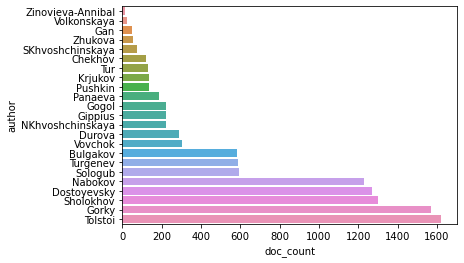

In [16]:
sns.barplot(data=by_author_stats, y='author', x='doc_count', order=by_author_stats.sort_values('doc_count').author)

In [17]:
print("How many tokens do we have for each author?")
tokens_by_author = by_author_stats.sort_values('token_count', ascending=False)
tokens_by_author['token_count'].describe()

How many tokens do we have for each author?


count        23.000000
mean     212582.043478
std      240727.518759
min        5468.000000
25%       52579.000000
50%       92444.000000
75%      241317.000000
max      761187.000000
Name: token_count, dtype: float64

In [18]:
print("Most prolific by tokens")
display(tokens_by_author.head())
print("Least prolific by tokens")
display(tokens_by_author.tail())

Most prolific by tokens


,author,doc_count,token_count,normalized_doc_length
10,Nabokov,1228,761187,619.859121
2,Dostoyevsky,1271,666135,524.103068
16,Tolstoi,1621,645444,398.176434
7,Gorky,1570,610311,388.733121
14,Sholokhov,1301,485131,372.890853


Least prolific by tokens


,author,doc_count,token_count,normalized_doc_length
13,SKhvoshchinskaya,77,31906,414.363636
4,Gan,52,28283,543.903846
21,Zhukova,56,27210,485.892857
19,Volkonskaya,25,10081,403.240000
22,Zinovieva-Annibal,15,5468,364.533333


<AxesSubplot:xlabel='token_count', ylabel='author'>

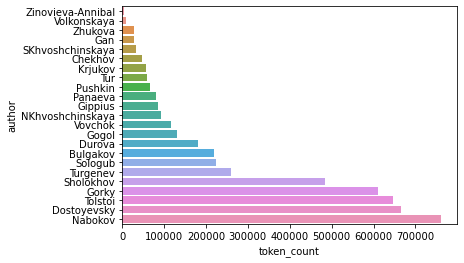

In [19]:
sns.barplot(data=tokens_by_author, y='author', x='token_count', order=tokens_by_author.sort_values('token_count').author)

In [20]:
print("Are there some authors that tend to have longer, 'denser' paragraphs/documents?")
by_author_stats['normalized_doc_length'].describe()


Are there some authors that tend to have longer, 'denser' paragraphs/documents?


count     23.000000
mean     446.015940
std       80.383768
min      364.533333
25%      386.881315
50%      414.363636
75%      486.729037
max      621.031034
Name: normalized_doc_length, dtype: float64

<AxesSubplot:xlabel='normalized_doc_length', ylabel='author'>

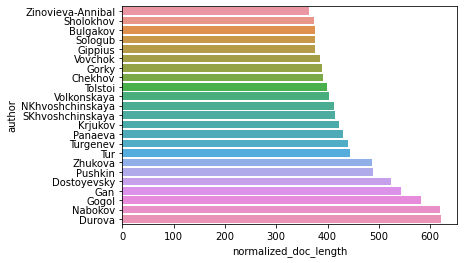

In [21]:
sns.barplot(data=tokens_by_author, y='author', x='normalized_doc_length', order=tokens_by_author.sort_values('normalized_doc_length').author)

In [22]:
# TODO Are there authors that use certain words at significantly higher rates than others?
clean_word_counts = get_by_author_word_counts(corpus, 'clean_text', 'author')
clean_word_counts.head()

,Pushkin,Zinovieva-Annibal,SKhvoshchinskaya,Krjukov,Turgenev,Nabokov,Sholokhov,Sologub,Zhukova,Panaeva,...,Bulgakov,Vovchok,Durova,Volkonskaya,Gan,Chekhov,Gippius,Gogol,Tur,Gorky
abandonner,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abattre,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abbasi,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aber,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Pruned corpus
Mallet corpus was pruned using the following settings:
- `MIN_TERM_FREQ := 5`: A term is pruned if it appears in less than 5 documents
 - `MIN_IDF := 1.39`: For Mallet, a given term's idf = ln(|corpus|/doc_freq), so 1.39 is 25% of corpus. Terms are pruned if they are in more than 25% of documents

Prune by running: `mallet prune --input input.mallet --output output_pruned.mallet --min-idf $(MIN_IDF) --prune-count $(MIN_TERM_FREQ)`


In [23]:
PRUNED_COUNTS = CORPUS_DIR / 'russian_novels_pruned_counts.tsv'
pruned_counts = pd.read_csv(PRUNED_COUNTS, sep='\t', encoding='utf-8', names=['word','term_freq', 'doc_freq']) 
display(pruned_counts.head())
print("Total tokens in pruned corpus according to Mallet (should be close to 'Total tokens' in next cell):", pruned_counts['term_freq'].sum())

,word,term_freq,doc_freq
0,точно,3785,2713
1,стал,3587,2703
2,этой,3446,2689
3,совсем,3731,2632
4,всего,3454,2607


Total tokens in pruned corpus according to Mallet (should be close to 'Total tokens' in next cell): 3473013


TODO: Tokenization differences likely account for the differences between what I got and Mallet, should probably pull the regex over from Mallet instead of just splitting on whitespace:
https://github.com/mimno/Mallet/blob/12487de1aa6433bdcf5af0ee0a17b368e64c7acf/src/cc/mallet/classify/tui/Csv2Vectors.java#L110

In [24]:
print("Document length statistics:")
print("Total tokens:", corpus['stopped_length'].sum())
display(corpus['stopped_length'].describe())
print("Total number of tokens dropped by pruning:", original_stop_counts['term_freq'].sum())
print("Vocabulary size after pruning:", len(pruned_counts['word']))

Document length statistics:
Total tokens: 3412131


count    10967.000000
mean       311.127109
std        158.907768
min          0.000000
25%        253.000000
50%        273.000000
75%        301.000000
max       3305.000000
Name: stopped_length, dtype: float64

Total number of tokens dropped by pruning: 1488296
Vocabulary size after pruning: 83512


In [25]:
pruned_counts_by_author = by_author_stats = get_by_author_statistics(corpus, 'author', 'stopped_length')
pruned_counts_by_author['token_count'].describe()

count        23.000000
mean     148353.521739
std      166585.290754
min        3557.000000
25%       37405.000000
50%       62826.000000
75%      171389.000000
max      520038.000000
Name: token_count, dtype: float64

In [26]:
print("Most prolific by tokens after pruning")
display(pruned_counts_by_author.head())
print("Least prolific by tokens after pruning")
display(pruned_counts_by_author.tail())

Most prolific by tokens after pruning


,author,doc_count,token_count,normalized_doc_length
0,Bulgakov,585,157952,270.003419
1,Chekhov,123,33912,275.707317
2,Dostoyevsky,1271,446422,351.236821
3,Durova,290,125495,432.741379
4,Gan,52,20399,392.288462


Least prolific by tokens after pruning


,author,doc_count,token_count,normalized_doc_length
18,Turgenev,589,182500,309.847199
19,Volkonskaya,25,6992,279.680000
20,Vovchok,305,80793,264.895082
21,Zhukova,56,18851,336.625000
22,Zinovieva-Annibal,15,3557,237.133333


<AxesSubplot:xlabel='token_count', ylabel='author'>

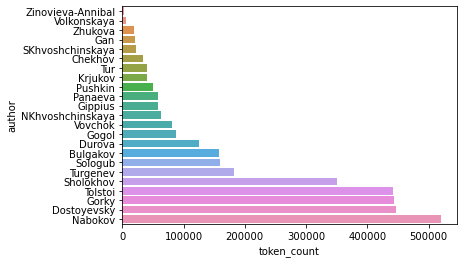

In [27]:
sns.barplot(data=pruned_counts_by_author, y='author', x='token_count', order=pruned_counts_by_author.sort_values('token_count').author)

In [28]:
print("Normalized token counts after pruning")
print("Are there some authors that tend to have longer, 'denser' paragraphs/documents?")
pruned_counts_by_author['normalized_doc_length'].describe()


Normalized token counts after pruning
Are there some authors that tend to have longer, 'denser' paragraphs/documents?


count     23.000000
mean     311.489949
std       54.740870
min      237.133333
25%      271.256799
50%      287.974026
75%      343.930911
max      432.741379
Name: normalized_doc_length, dtype: float64

<AxesSubplot:xlabel='normalized_doc_length', ylabel='author'>

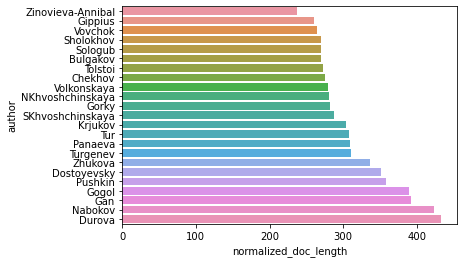

In [29]:
sns.barplot(data=pruned_counts_by_author, y='author', x='normalized_doc_length', order=pruned_counts_by_author.sort_values('normalized_doc_length').author)

In [30]:
stop_word_counts = get_by_author_word_counts(corpus, 'stopped_text', 'author')
stop_word_counts.head()

,Pushkin,Zinovieva-Annibal,SKhvoshchinskaya,Krjukov,Turgenev,Nabokov,Sholokhov,Sologub,Zhukova,Panaeva,...,Bulgakov,Vovchok,Durova,Volkonskaya,Gan,Chekhov,Gippius,Gogol,Tur,Gorky
aber,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ach,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ada,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
adieu,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
admirable,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Analysis of topics
A topic model was trained on the pruned corpus with the following settings:
- `NUM_TOPICS := 100`
- `NUM_ITERS := 1000`
- `OPTIMIZE_INTERVAL := 20`
- `OPTIMIZE_BURN_IN := 50`

Mallet training command:
`mallet train-topics $(MALLET_TOPIC_FLAGS) --input input_pruned.mallet --output-state $(state) --output-model $(output_model) --output-doc-topics $(doc_topics) --output-topic-keys $(topic_keys)`

In [31]:
EXPERIMENT_DIR = Path('/home/virginia/workspace/topic-modeling-study/russian_novels_first_experiment/russian_novels_100topics_1000iters')
# Mallet ouput with manually added comments on topic quality
TOPIC_KEYS = EXPERIMENT_DIR / 'russian_novels_100topics_1000iters_topic_keys_with_comments.tsv'

In [32]:
topics = pd.read_csv(TOPIC_KEYS, sep='\t', encoding='utf-8', index_col=0)
topics.head()

,topic_proportion_per_doc,tokens,comment
tid,,,
0,0.01269,вера александровна любовь васильевна ольга зоя...,Names
1,0.09763,чай стакан стол вина стола вино пить выпил вод...,"Drinking – tea, cup, table, wine, vodka, coffee"
2,0.04519,самгин самгина клим самгину варвара точно чтоб...,Gorky – The Life of Klim Samgin
3,0.01990,франц марта драйер поезд вагона станции вагон ...,"Traveling and trains, but also Franz Dreyer fr..."
4,0.21084,могла говорила сама знала думала хотела говори...,Past tense feminine verbs


## Author entropy
Produced with command:
`python ~/workspace/authorless-tms/topic_author_correlation.py --input russian_novels.tsv --vocab russian_novels_pruned_vocab.txt --input-state russian_novels_100topics_1000iters/russian_novels_100topics_1000iters.gz --output russian_novels_100topics_1000iters/russian_novels_100topics_1000iters_author_correlation.tsv`


In [33]:
AUTHOR_CORRELS = EXPERIMENT_DIR /'russian_novels_100topics_1000iters_author_correlation.tsv'

In [34]:
author_correls = pd.read_csv(AUTHOR_CORRELS, sep='\t', encoding='utf-8', index_col=0)
author_correls.head()

,Author Entropy,Minus Major Author,Balanced Authors
Topic,,,
0,1.713103,0.172548,0.212536
1,2.581627,0.011270,0.065647
2,0.206651,0.428270,0.443944
3,1.347237,0.198656,0.296218
4,2.496419,0.008288,0.024083


<AxesSubplot:xlabel='Author Entropy', ylabel='Count'>

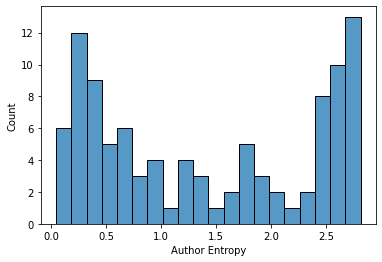

In [35]:
sns.histplot(data=author_correls['Author Entropy'], bins=20)

<AxesSubplot:xlabel='Minus Major Author', ylabel='Count'>

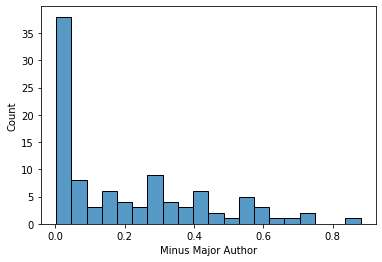

In [36]:
sns.histplot(data=author_correls['Minus Major Author'], bins=20)

<AxesSubplot:xlabel='Balanced Authors', ylabel='Count'>

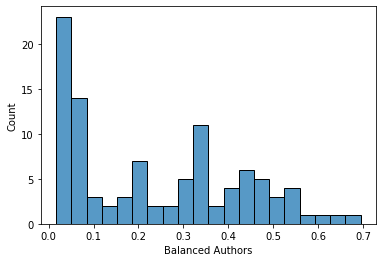

In [37]:
sns.histplot(data=author_correls['Balanced Authors'], bins=20)

In [38]:
# TODO Join in top documents per topic here
topics_with_entropy = pd.merge(topics, author_correls, left_index=True, right_index=True)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
# Sort by increasing entropy - lower entropy means a single author dominates that topic
# Higher Minus Major Author or Balanced Authors means that the distribution changes significantly,
# so a single author is using terms differently from others
topics_with_entropy.sort_values("Author Entropy").head(100)


,topic_proportion_per_doc,tokens,comment,Author Entropy,Minus Major Author,Balanced Authors
tid,,,,,,
64,0.00204,мнe лида нeт ардалион феликс герман вeдь себe мое всe тебe гдe тeм мной моя человeк нeсколько дeло помню моей,Pronouns,0.042837,0.879995,0.694735
89,0.00759,пнин пнина гаген тимофей пнину профессор своего миссис доктор клементс шато снова джоун свой бетти друг джоан д-р лиза которая,Nabokov – Pnin,0.103448,0.733001,0.628492
36,0.00530,нежданов марианна соломин паклин сипягин маркелов нежданова калломейцев валентина машурина михайловна нежданову промолвил маркелова сипягина соломина татьяна начал алексей остродумов,Names,0.134090,0.721145,0.622843
81,0.01087,ван ада вана люсетта марина ады демон вану the аде аду мадемуазель вин ларивьер адой бланш демона моя миг ардис,Nabokov – Ada,0.146696,0.664453,0.578167
91,0.00518,граф евстафий чтоб астольда графа евстафия кауни тодеуш астольды этаго графиня нибудь своего однакож клутницкий гедвига надобно торгайло торгайлы котораго,'Count' and 'Countess' ?,0.156809,0.619591,0.542143
80,0.02326,клим лидия макаров клима лютов климу варавка иноков самгин спивак алина туробоев лидии дронов чтоб пред мать макарова диомидов дмитрий,Gorky – The Life of Klim Samgin,0.166438,0.544568,0.524330
24,0.01706,давыдов нагульнов макар разметнов давыдова факт товарищ колхоза колхоз почему давыдову лушка кондрат любишкин председатель нагульнова хлеб макара быков партии,collective farming – Sholokov,0.191821,0.541757,0.513858
40,0.00691,ортруда королева танкред афра всё меччио королевы ортруды танкреда астольф лорена имогена виктор ещё принца принц филиппо ортруде ортруду спросила,?,0.192856,0.588590,0.523801
2,0.04519,самгин самгина клим самгину варвара точно чтоб марина подумал пред снова дронов затем иванович тагильский вообще чорт безбедов кутузов сердито,Gorky – The Life of Klim Samgin,0.206651,0.428270,0.443944


## Morphological analysis of topics
Questions to answer:
- Which topics have multiple words with the same lemma? What about morphological variation on proper names?
- Which lemmas appear frequently across different topics? 
- Which topics contain many words of the same morphological type (e.g. past tense feminine sg verbs)? What types?
- Type-token ratio and character-token ration broken down by author